### First approach

In [1]:
import os

os.chdir("/home/adamczykb/rnaquanet/src")
os.environ['MLFLOW_TRACKING_USERNAME']='admin'
os.environ['MLFLOW_TRACKING_PASSWORD']='TI5du9by'

In [52]:
import torch
import torch.nn as nn
from rnaquanet.dataset.RNAQuANetDataset import RNAQuANetDataset
from rnaquanet.dataset.RNAQuANetDataset import RNAQuANetDatasetSubset

from torch_geometric import nn as gnn
import lightning as L
from torch_geometric.loader import DataLoader
from numpy import inf


In [55]:
class RNAQuANet(L.LightningModule):
    def __init__(self, number_of_node_features: int):
        super().__init__()
        self.save_hyperparameters()
        self.norm1 = gnn.BatchNorm(number_of_node_features)

        self.GATconv1 = gnn.GATv2Conv(
            number_of_node_features, number_of_node_features, heads=4, edge_dim=35
        )

        self.GATconv2 = gnn.GATv2Conv(
            number_of_node_features * 4, number_of_node_features, heads=4, edge_dim=35
        )
        self.GATconv3 = gnn.GATv2Conv(
            number_of_node_features * 4, number_of_node_features, heads=4, edge_dim=35
        )

        self.GCN2Conv1 = gnn.GeneralConv(
            number_of_node_features * 4, number_of_node_features , in_edge_channels=35
        )
       
        self.fc1 = nn.Linear(number_of_node_features, number_of_node_features)
        self.fc3 = nn.Linear(number_of_node_features, 1)
        self.dropout = nn.Dropout(0.2)
        self.activation = nn.ReLU()
        self.aggregation = gnn.aggr.SetTransformerAggregation(
            number_of_node_features,dropout=0.2,layer_norm=True
        )

    def forward(self, x, edge_index, edge_attr, batch):

        y = self.norm1(x)
        y = self.GATconv1(y, edge_index, edge_attr)
        y = self.activation(y)
        y = self.dropout(y)
        y = self.GATconv2(y, edge_index, edge_attr)
        y = self.activation(y)
        y = self.dropout(y)
        y = self.GATconv3(y, edge_index, edge_attr)
        y = self.activation(y)
        y = self.dropout(y)
        y = self.GCN2Conv1(y, edge_index, edge_attr)
        y = self.activation(y)
        y = self.dropout(y)

        y = self.aggregation(y, batch)

        y = self.fc1(y)
        y = self.activation(y)
        y = self.dropout(y)


        y = self.fc3(y)

        return self.activation(y)

    def training_step(self, data, batch_idx):
        result = self.forward(data.x, data.edge_index, data.edge_attr, data.batch)

        loss = (torch.abs(result - data.y.unsqueeze(-1))).mean()
        loss_mse = (torch.square(torch.abs(result - data.y.unsqueeze(-1)))).mean()

        self.log("train_loss_mae", loss, batch_size=125)
        self.log("train_loss_mse", loss_mse, batch_size=125)
        return loss

    def validation_step(self, data, batch_idx):
        result = self.forward(data.x, data.edge_index, data.edge_attr, data.batch)
        loss = (torch.abs(result - data.y.unsqueeze(-1))).mean()
        loss_mse = (torch.square(torch.abs(result - data.y.unsqueeze(-1)))).mean()

        self.log("val_loss_mae", loss, batch_size=125)
        self.log("val_loss_mse", loss_mse, batch_size=125)
        return loss_mse

    def backward(self, loss):
        loss.backward()

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=1e-4)
        return optimizer

In [12]:
CUTOFF=5.0
SUBSETS=[RNAQuANetDatasetSubset.ALL]

In [10]:
import enum


class DATASET(enum.Enum):
    RNAQUANET = {'name':'rnaquanet','path':'rnaquanet_structures'}
    ARES = {'name':'ares','path':'ares'}

dataset = DATASET.ARES

In [13]:
dataset_train = RNAQuANetDataset(
    f"/home/adamczykb/rnaquanet/data/06_model_input/{dataset.value['path']}/train",
    subsets=SUBSETS,
    cutoff=CUTOFF,
)
dataset_val = RNAQuANetDataset(
    f"/home/adamczykb/rnaquanet/data/06_model_input/{dataset.value['path']}/val",
    subsets=SUBSETS,
    cutoff=CUTOFF,
)

In [8]:
dataset_train.print_summary()

RNAQuANetDataset (#graphs=7000):
+------------+----------+----------+
|            |   #nodes |   #edges |
|------------+----------+----------|
| mean       |     29   |    321.6 |
| std        |      7.9 |    108.3 |
| min        |     22   |    140   |
| quantile25 |     24   |    248   |
| median     |     26   |    284   |
| quantile75 |     32   |    346   |
| max        |     47   |    700   |
+------------+----------+----------+


In [9]:
dataset_val.print_summary()

RNAQuANetDataset (#graphs=3000):
+------------+----------+----------+
|            |   #nodes |   #edges |
|------------+----------+----------|
| mean       |     23.7 |    251.1 |
| std        |      3.7 |     60.7 |
| min        |     19   |    144   |
| quantile25 |     19   |    198   |
| median     |     24   |    242   |
| quantile75 |     28   |    298   |
| max        |     28   |    448   |
+------------+----------+----------+


In [56]:
from lightning.pytorch import seed_everything
from lightning.pytorch.callbacks import RichProgressBar
from lightning.pytorch.callbacks.early_stopping import EarlyStopping
from lightning.pytorch.callbacks.model_checkpoint import ModelCheckpoint
from lightning.pytorch.callbacks.progress.rich_progress import RichProgressBarTheme
from lightning.pytorch.loggers import MLFlowLogger

seed_everything(42)


class MetricTracker(L.Callback):
    def __init__(self):
        self.collection = []

    def on_validation_batch_end(self, trainer, pl_module, outputs, batch, batch_idx):
        vacc = outputs["val_loss_mae"]  # you can access them here
        self.collection.append(vacc)  # track them

    def on_validation_epoch_end(self, trainer, module):
        elogs = trainer.logged_metrics["val_loss_mae"]  # access it here
        self.collection.append(elogs)
        # do whatever is needed


model_name = f"RNAQuANet-{dataset.value['name']}_dataset__{'_'.join([s.value for s in SUBSETS])}"
model = RNAQuANet(dataset_train[0].x.shape[1])
mlf_logger = MLFlowLogger(
    experiment_name=f"{model_name}",
    tracking_uri="https://www.bartekadamczyk.eu/mlflow",
    log_model="all",
)
mlf_logger.log_hyperparams(
    {
        "model_name": model_name,
        "dataset_cutoff": CUTOFF,
        "subset": {'_'.join([s.value for s in SUBSETS])},
        "dataset_size_train": len(dataset_train),
        "dataset_size_val": len(dataset_val),
        "dataset_train_summary": dataset_train.get_summary(),
        "dataset_val_summary": dataset_val.get_summary(),
    }
)
torch.set_float32_matmul_precision("high")
metr = MetricTracker()

# create your own theme!
progress_bar = RichProgressBar(
    theme=RichProgressBarTheme(
        metrics_text_delimiter="\n",
        metrics_format=".3e",
    )
)


train_loader = DataLoader(dataset_train, num_workers=24, batch_size=125, shuffle=True)
val_loader = DataLoader(dataset_val, num_workers=24, batch_size=125)
model_checkpoint = ModelCheckpoint(monitor="val_loss_mae", save_top_k=1, mode="min")
trainer = L.Trainer(
    max_epochs=400,
    enable_progress_bar=True,  # callbacks=progress_bar,
    default_root_dir=f"/home/adamczykb/rnaquanet/checkpoints/{model_name}",
    log_every_n_steps=25,
    callbacks=[
        EarlyStopping(monitor="val_loss_mae", mode="min", patience=30),
        model_checkpoint
    ],
    logger=mlf_logger,
)
trainer.fit(model=model, train_dataloaders=train_loader, val_dataloaders=val_loader)


Seed set to 42
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name        | Type                      | Params | Mode 
------------------------------------------------------------------
0 | norm1       | BatchNorm                 | 158    | train
1 | GATconv1    | GATv2Conv                 | 62.3 K | train
2 | GATconv2    | GATv2Conv                 | 212 K  | train
3 | GATconv3    | GATv2Conv                 | 212 K  | train
4 | GCN2Conv1   | GeneralConv               | 52.9 K | train
5 | fc1         | Linear                    | 6.3 K  | train
6 | fc3         | Linear                    | 80     | train
7 | dropout     | Dropout                   | 0      | train
8 | activation  | ReLU                      | 0      | train
9 | aggregation | SetTransformerAggregation | 102 K  | train
------------------------------------------------------------------
647 K     Trainable p

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

🏃 View run shivering-pug-974 at: https://www.bartekadamczyk.eu/mlflow/#/experiments/306037256498709437/runs/e8c1322278694a93890be0b2d3fdcfc6
🧪 View experiment at: https://www.bartekadamczyk.eu/mlflow/#/experiments/306037256498709437


In [54]:
best_model_path='/home/adamczykb/rnaquanet/RNAQuANet_transformer_dataset__all/696898214243479817/43425cc33d2e4a1fa86f098cc3fd7d6d/checkpoints/epoch=35-step=2448.ckpt'

In [58]:
best_model_path='/home/adamczykb/rnaquanet/RNAQuANet_transformer_ares_dataset__all/306037256498709437/ea35e4e61ff147fcbdb2c0da91520616/checkpoints/epoch=29-step=1680.ckpt'

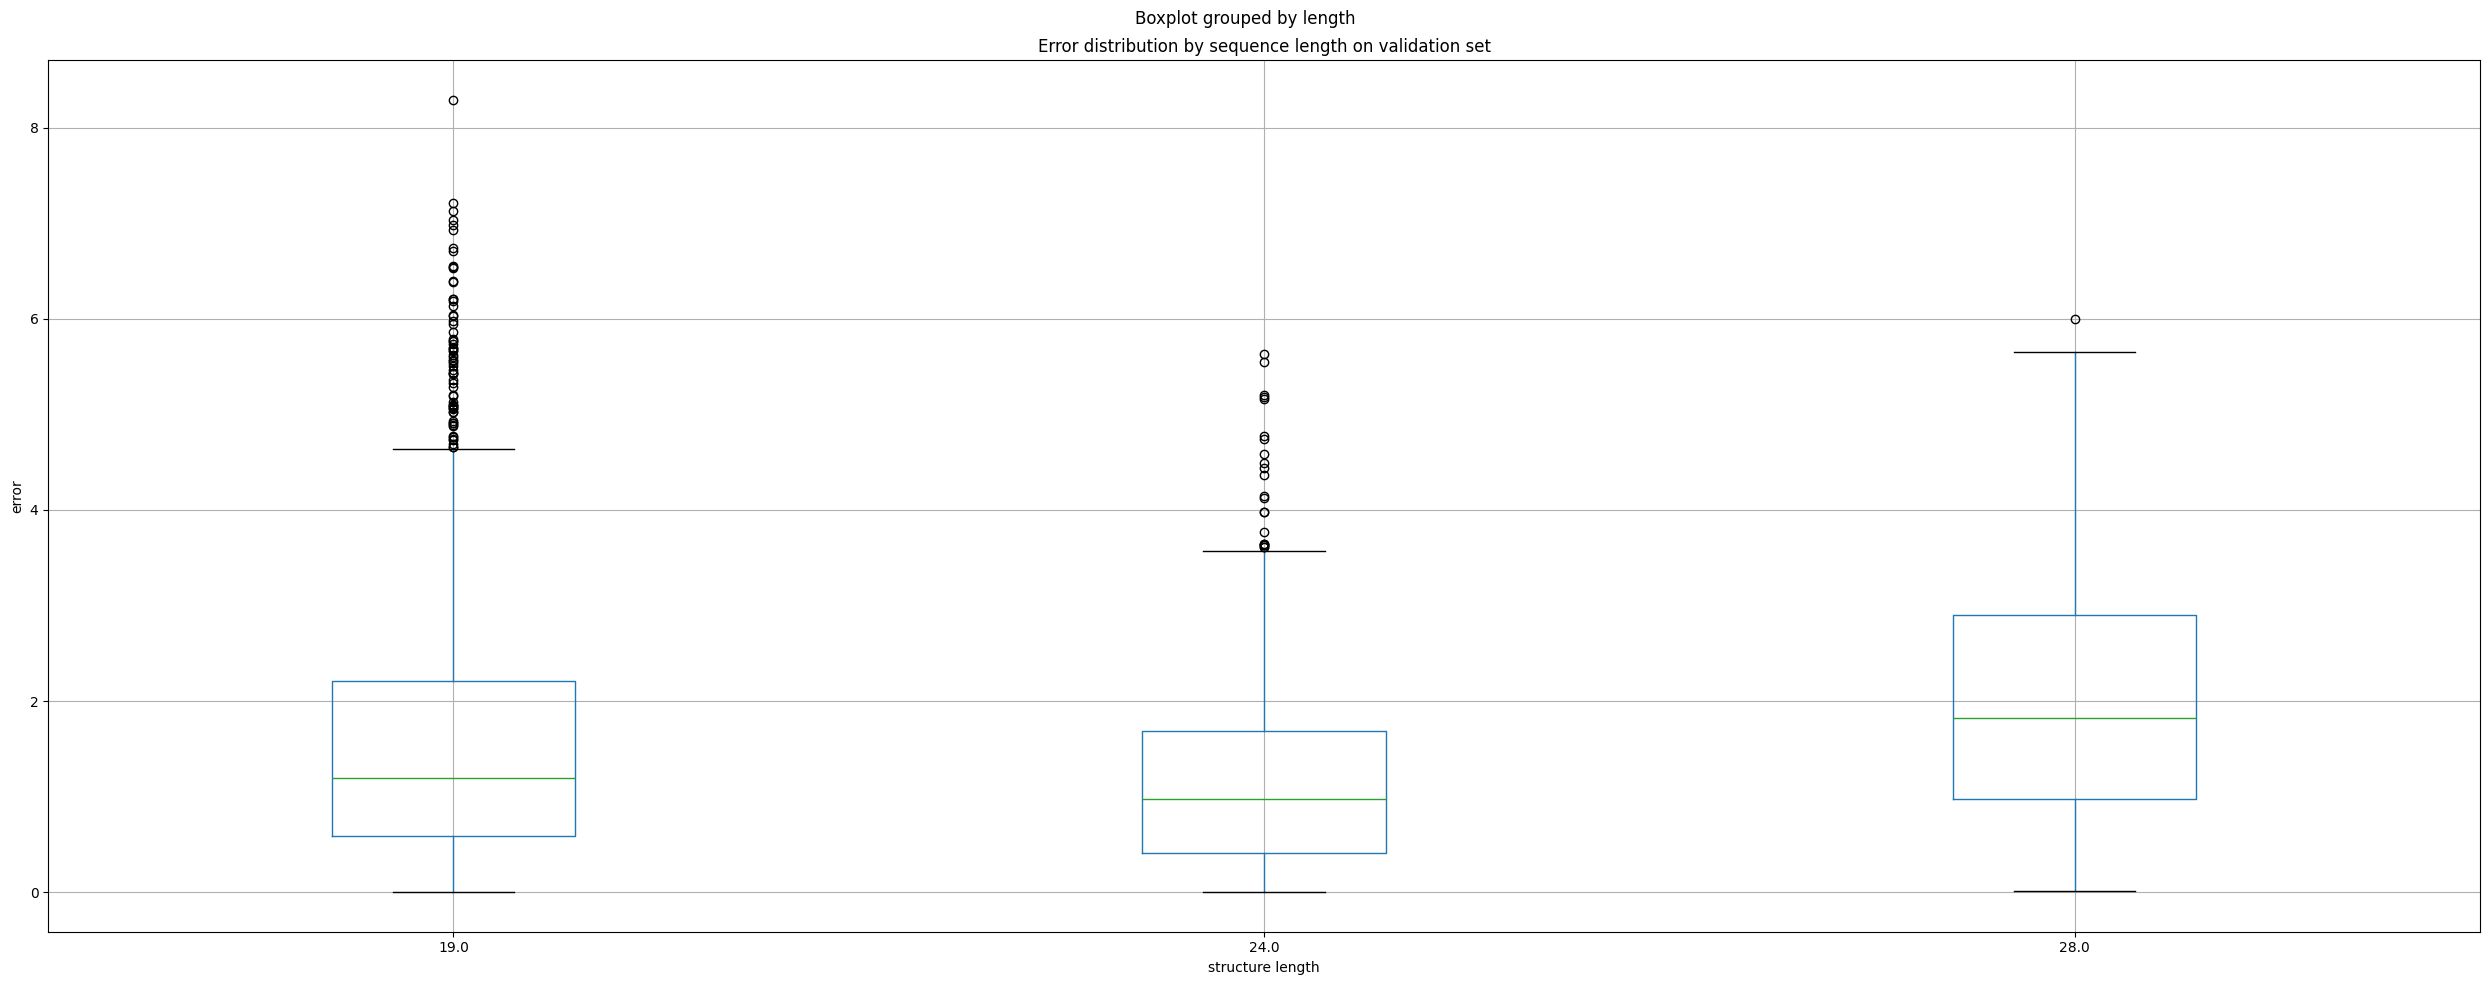

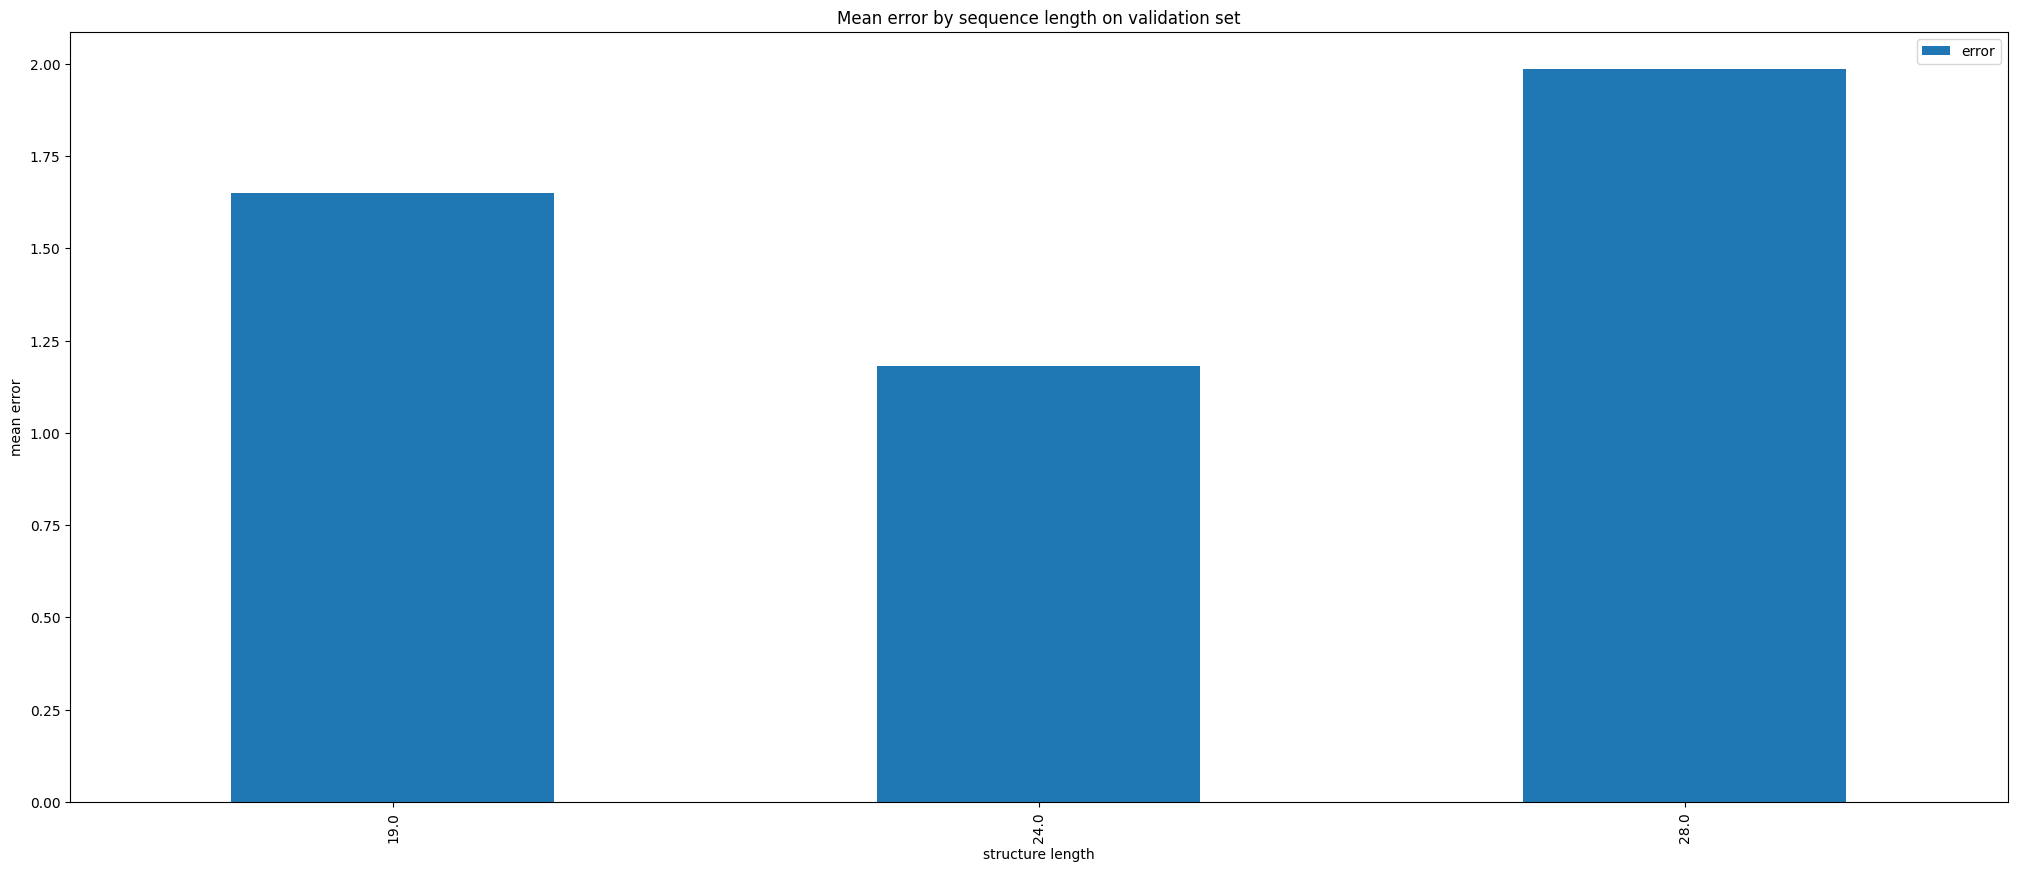

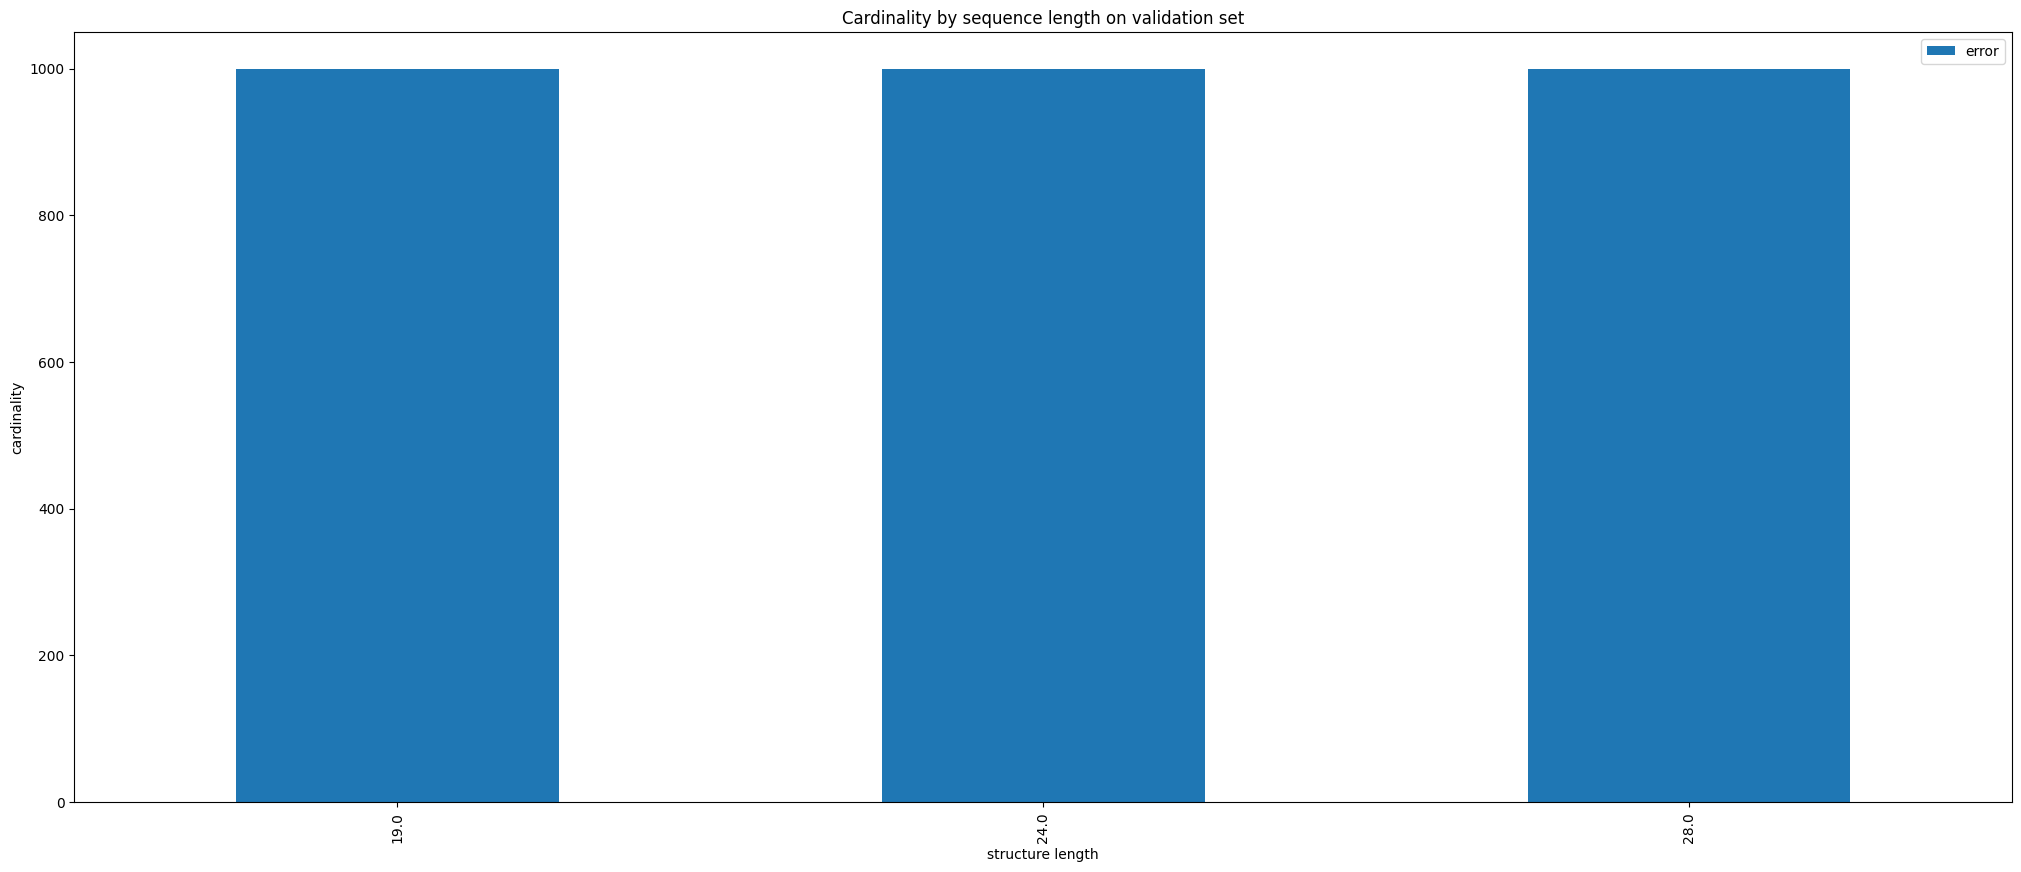

In [57]:
import mlflow
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

val_model = RNAQuANet.load_from_checkpoint(
    model_checkpoint.best_model_path,
    number_of_node_features=dataset_train[0].x.shape[1],strict=False
)
val_model=val_model.eval()
res = []
for i in dataset_val:
    res.append(
        [
            i.x.shape[0],
            float(
                abs(
                    i.y.cpu()
                    - val_model(i.x.cuda(), i.edge_index.cuda(), i.edge_attr.cuda(), torch.zeros(i.x.shape[0],dtype=torch.int64).cuda()).detach().cpu().numpy()
                )
            ),
        ]
    )
df = pd.DataFrame(np.array(res), columns=["length", "error"])
fig, ax = plt.subplots(figsize=(25, 10))

df.boxplot(column="error", by="length", ax=ax)
ax.set_xlabel("structure length")
ax.set_ylabel("error")
ax.set_title("Error distribution by sequence length on validation set")
plt.tight_layout()
mlf_logger.experiment.log_figure(mlf_logger.run_id,fig, "error_distribution_by_length.svg")
mlf_logger.experiment.log_text(mlf_logger.run_id,str(val_model.eval()), "architecture.txt")
plt.show()

fig, ax = plt.subplots(figsize=(25, 10))
df.groupby("length").mean().plot(kind="bar", ax=ax)
ax.set_xlabel("structure length")
ax.set_ylabel("mean error")
ax.set_title("Mean error by sequence length on validation set")
mlf_logger.experiment.log_figure(mlf_logger.run_id,fig, "error_mean_by_length.svg")
plt.show()

fig, ax = plt.subplots(figsize=(25, 10))
df.groupby("length").count().plot(kind="bar", ax=ax)

ax.set_xlabel("structure length")
ax.set_ylabel("cardinality")
ax.set_title("Cardinality by sequence length on validation set")
mlf_logger.experiment.log_figure(mlf_logger.run_id, fig, "cardinality_by_length.svg")
plt.show()

mlf_logger.experiment.log_metric(mlf_logger.run_id,"best_val_loss_mae", model_checkpoint.best_model_score.cpu().tolist())
mlf_logger.experiment.log_metric(mlf_logger.run_id,"best_val_loss_mse", (df["error"]**2.0).mean())


In [58]:
model_checkpoint.best_model_path

'/home/adamczykb/rnaquanet/checkpoints/RNAQuANet-ares_dataset__all/306037256498709437/e8c1322278694a93890be0b2d3fdcfc6/checkpoints/epoch=16-step=952.ckpt'

In [50]:
val_model = RNAQuANet.load_from_checkpoint(
'/home/adamczykb/rnaquanet/checkpoints/RNAQuANet-ares_dataset__all/306037256498709437/907d0b5d821048268dfe231227affa42/checkpoints/epoch=11-step=672.ckpt',
    number_of_node_features=dataset_train[0].x.shape[1],strict=False
)
val_model.eval()
val_model._trainer = L.Trainer()
m=torch.jit.script(val_model).cuda()
torch.jit.save(m,f"/tmp/{mlf_logger.run_id}.pt")
mlf_logger.experiment.log_artifact(mlf_logger.run_id,
    f"/tmp/{mlf_logger.run_id}.pt",
    artifact_path="model"
)

mlflow.pytorch.log_model(mlf_logger.run_id, val_model, "models")

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


NotSupportedError: Compiled functions can't take variable number of arguments or use keyword-only arguments with defaults:
  File "/home/adamczykb/rnaquanet/.venv/lib/python3.13/site-packages/torch_geometric/nn/conv/message_passing.py", line 425
        edge_index: Adj,
        size: Size = None,
        **kwargs: Any,
         ~~~~~~~ <--- HERE
    ) -> Tensor:
        r"""The initial call to start propagating messages.


In [33]:
train_loader = DataLoader(dataset_train, num_workers=24, batch_size=125, shuffle=True)

